In [ ]:
import hyperopt as hp
import numpy as np
import scipy as sc


import uci_datasets as uci

from sklearn.preprocessing import StandardScaler
import sklearn as sk
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import mlflow
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
from datetime import datetime
import torch.nn as nn
import cvxpy as cp
import mlflow.pytorch
from mlflow.models.signature import infer_signature, set_signature
import hyperopt
from functools import partial
import pandas as pd
import seaborn as sns
from wadiroscnn import scnn
import bench_data_selection as bench


In [ ]:
choice_space = False
if choice_space:
    space_lof = {
            'n_neighbors': hp.choice('n_neighbors', [5,10,20,30,40,50,60,70,80,90,100]),
            'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
            'leaf_size': hp.choice('leaf_size',[ 5, 10, 20,30, 40, 50, 60, 70, 80, 90, 100]),
            'metric': hp.choice('metric', ['euclidean', 'manhattan'])
        }

    

    space_sw = {
            'eps': hp.choice('eps', [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4]),
            'n': hp.choice('n', [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]),
            'n_projections': hp.choice('n_projections', [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]),
            'p' : hp.choice('p', [0.6, 0.7, 0.8, 0.9, 0.95])
        }

    space_sw_smartsplit = space_sw | {
            'n_clusters' : hp.choice('n_clusters', [2, 3, 4, 5, 6, 7, 8, 9, 10]),
            'n_splits' : hp.choice('n_splits', [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30])
        }


    space_fast_euclidian = {
            'eps': hp.choice('eps', [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4]),
            'n': hp.choice('n', [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]),
            'p': hp.choice('p', [0.6, 0.7, 0.8, 0.9, 0.95])
        }
else:
    space_lof = {
            'n_neighbors': hp.quniform('n_neighbors', 5, 300, 1),
            'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
            'leaf_size': hp.quniform('leaf_size', 5, 300, 1),
            'metric': hp.choice('metric', ['euclidean', 'manhattan'])
        }
    
    space_sw = {
            'eps': hp.loguniform('eps', -12, 1),
            'n': hp.choice('n', [150, 300]),
            'n_projections': hp.choice('n_projections', [40]),
            'p' : hp.choice('p', [0.7, 0.8, 0.9])
        }
    
    space_sw_smartsplit = space_sw | {
            'n_clusters' : hp.choice('n_clusters', [3]),
            'n_splits' : hp.choice('n_splits', [3])
        }
    
    space_fast_euclidian = {
            'eps': hp.loguniform('eps', -12, 7),
            'n': hp.choice('n', [150, 300]),
            'p' : hp.choice('p', [0.7, 0.8, 0.9])
        }
    
    space_forest = {
            'n_estimators': hp.quniform('n_estimators', 5, 300, 1),
            'max_samples': hp.uniform('max_samples', 0.000001, 1.0),
            'contamination': hp.loguniform('contamination', -7, -0.7),
            'max_features': hp.uniform('max_features', 0.00001, 1.0)
        }
    
    

In [ ]:
space_scnn = {'max_neurons': hp.choice('max_neurons', [25])}# #20, 50, 100, 200, 300, 500])}
                
space_scnn_sw =  space_scnn | space_sw

space_scnn_sw_smartsplit =  space_scnn | space_sw_smartsplit

space_scnn_fast_euclidian =  space_scnn | space_fast_euclidian

space_scnn_forest = space_scnn | space_forest

space_scnn_lof = space_scnn | space_lof

First, run this from terminal :

mlflow server --host 127.0.0.1 --port 8081

In [6]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# Create a new MLflow Experiment
experiment = mlflow.set_experiment("COMPARISON_DATA_SELECTION_100runs_split_2_noise_V3")

# Get Experiment Details
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Name: {}".format(experiment.name))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

Experiment_id: 942686871926779159
Artifact Location: mlflow-artifacts:/942686871926779159
Name: COMPARISON_DATA_SELECTION_100runs_split_2_noise_V3
Tags: {}
Lifecycle_stage: active


In [ ]:
DATASET_LIST = [ 
       'stock',
	'concrete',
       'energy',
       'solar', 
       'forest', 
       'wine',  #'airfoil', # 'energy', 'forest',
	]

ALGORITHM_LIST = ['none',
                  'fast_euclidian', 
                  'lof', 
                  'forest', 
                  'sw_smartsplit', 
                  ]


solver_name = 'CLARABEL'
verbose = False
MAX = 100
NOISE_VAR_X = 0.05
NOISE_VAR_Y = 0.05

splits = [3]

print(splits)

In [ ]:

for i in splits:
    for dataset_name in DATASET_LIST:
        for selection_algorithm in ALGORITHM_LIST:
            rng = np.random.default_rng(i)
            # import data
            uci_data = uci.Dataset(dataset_name)
            X_train, Y_train, X_test, Y_test = uci_data.get_split(split = int(i))
            

            X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

            scaler_x = StandardScaler()
            scaler_y = StandardScaler()

            # Fit and transform the features
            X_train_scaled = scaler_x.fit_transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)
            X_test_scaled = scaler_x.transform(X_test)

            Y_train_scaled = scaler_y.fit_transform(Y_train)
            Y_val_scaled = scaler_y.transform(Y_val)
            Y_test_scaled = scaler_y.transform(Y_test)

            X_train_scaled += rng.normal(0, NOISE_VAR_X, X_train_scaled.shape)
            X_val_scaled += rng.normal(0, NOISE_VAR_X, X_val_scaled.shape)
            Y_train_scaled += rng.normal(0, NOISE_VAR_Y, Y_train_scaled.shape)
            Y_val_scaled += rng.normal(0, NOISE_VAR_Y, Y_val_scaled.shape)

            data = {"X_train": X_train, "Y_train": Y_train,"X_val": X_val , "Y_val":Y_val,  "X_test": X_test, "Y_test": Y_test, "X_train_scaled": X_train_scaled, "Y_train_scaled": Y_train_scaled, "X_val_scaled": X_val_scaled ,"Y_val_scaled": Y_val_scaled ,"X_test_scaled": X_test_scaled, "Y_test_scaled": Y_test_scaled, 'scaler_y': scaler_y, 'scaler_x': scaler_x}

            if selection_algorithm == 'lof':
                search_space = space_scnn_lof
                max_evals = MAX
            elif selection_algorithm == 'sw':
                search_space = space_scnn_sw
                max_evals = MAX
            elif selection_algorithm == 'sw_smartsplit':
                search_space = space_scnn_sw_smartsplit
                max_evals = MAX
            elif selection_algorithm == 'fast_euclidian':
                search_space = space_scnn_fast_euclidian
                max_evals = MAX
            elif selection_algorithm == 'forest':
                search_space = space_scnn_forest
                max_evals = MAX
            elif selection_algorithm == 'none':
                max_evals = 2
                search_space = space_scnn
            else:
                raise ValueError("Unknown selection algorithm")
            
            print(f"SCNN on {dataset_name} with {selection_algorithm}: \n")
            fmin_scnn = partial(bench.objective_scnn, data = data, solver_name=solver_name, experiment=experiment, dataset_name=dataset_name, verbose=verbose, selection_algorithm=selection_algorithm, split = i)
            argmin = fmin(fn=fmin_scnn,
                    space=search_space,
                    algo= hyperopt.tpe.suggest, #partial(bench.suggest, nbMaxSucessiveFailures=1000), #hyperopt.tpe.suggest, # try anneal.suggest
                    max_evals=max_evals) #trials=spark_trials)
            


## Extract results

In [3]:
import hyperopt as hp
import numpy as np
import scipy as sc


import uci_datasets as uci

from sklearn.preprocessing import StandardScaler
import sklearn as sk
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import mlflow
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
from datetime import datetime
import torch.nn as nn
import cvxpy as cp
import mlflow.pytorch
from mlflow.models.signature import infer_signature, set_signature
import hyperopt
from functools import partial
import pandas as pd
import seaborn as sns
from wadiroscnn import scnn
import bench_data_selection as bench


In [7]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
experiment = mlflow.set_experiment("COMPARISON_DATA_SELECTION_100runs_split_2_noise_V3")

# Get Experiment Details
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Name: {}".format(experiment.name))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

Experiment_id: 942686871926779159
Artifact Location: mlflow-artifacts:/942686871926779159
Name: COMPARISON_DATA_SELECTION_100runs_split_2_noise_V3
Tags: {}
Lifecycle_stage: active


In [8]:
df = mlflow.search_runs([experiment.experiment_id],filter_string="status = 'FINISHED'")
#building_ids = df['params.building_id']

datasets = df['params.dataset'].unique()
print(datasets)
models = df['tags.model_name'].unique()
print(models)

splits = df['params.split'].unique()
print(splits)



['wine' 'forest' 'solar' 'energy' 'concrete' 'stock']
['scnn_and_sw_smartsplit' 'scnn_and_forest' 'scnn_and_lof'
 'scnn_and_fast_euclidian' 'scnn_and_none']
['3' '2']


In [9]:
import json
result_dict = {}
mean_dict = {}

for split in splits:
    for dataset in datasets:
        for model in models:
            best_val= df.loc[(df['params.dataset'] == dataset) & (df['tags.model_name'] == model) & (df['params.split']==split)].sort_values(by=['metrics.MAE_val', 'end_time'], ascending=True).head(1)

            #best_mse = df.loc[(df['params.benchmark_functions'] == function) & (df['tags.model_name'] == model)].sort_values(by='metrics.MSE_val', ascending=True).head(1)
            #best_build = df.loc[ (df['tags.model_name'] == model)].sort_values(by='metrics.MAE_VAL_all_buildings_scaled', ascending=True).head(1)

            if f'{dataset}' not in result_dict.keys():
                result_dict[f'{dataset}'] = {}
            if f'{model}' not in result_dict[f'{dataset}'].keys():
                result_dict[f'{dataset}'][f'{model}'] = {}

            #display(best_val)
        
            result_dict[f'{dataset}'][f'{model}'][f'{split}'] = {'MAE_test': best_val['metrics.MAE_test'].values[0], 'RMSE_test' : best_val['metrics.RMSE_test'].values[0], 'n_outliers': best_val['metrics.n_outliers'].values[0]}


mean_dict = {}

for dataset in result_dict.keys():
    for model in result_dict[dataset].keys():
        # Initialize the mean_dict structure for the current dataset and model
        if dataset not in mean_dict:
            mean_dict[dataset] = {}
        if model not in mean_dict[dataset]:
            mean_dict[dataset][model] = {}

        # Calculate the mean for each metric across all splits
        mean_dict[dataset][model] = {
            'MAE_test': np.mean([result_dict[dataset][model][split]['MAE_test'] for split in result_dict[dataset][model].keys()]),
            'RMSE_test': np.mean([result_dict[dataset][model][split]['RMSE_test'] for split in result_dict[dataset][model].keys()]),
            'n_outliers': np.mean([result_dict[dataset][model][split]['n_outliers'] for split in result_dict[dataset][model].keys()])
        }


In [10]:
df_2 = pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in mean_dict.items()
    }, 
    axis=0)
print(df_2)

                                  MAE_test  RMSE_test  n_outliers
wine     scnn_and_sw_smartsplit   0.455893   0.642829         5.5
         scnn_and_forest          0.451271   0.649271         6.5
         scnn_and_lof             0.459312   0.634654        49.5
         scnn_and_fast_euclidian  0.454204   0.637565         3.5
         scnn_and_none            0.449781   0.635002         0.0
forest   scnn_and_sw_smartsplit   1.533576   2.055236         1.0
         scnn_and_forest          1.593564   2.143530         3.0
         scnn_and_lof             1.596239   2.200138         4.5
         scnn_and_fast_euclidian  1.535192   1.964536       154.0
         scnn_and_none            1.627347   2.160970         0.0
solar    scnn_and_sw_smartsplit   0.304477   0.847612       338.5
         scnn_and_forest          0.320462   0.835978       149.0
         scnn_and_lof             0.357660   0.839883        81.5
         scnn_and_fast_euclidian  0.295798   0.757577       339.5
         s

In [11]:

data_MAE = pd.DataFrame(columns=datasets, index=models)
data_RMSE = pd.DataFrame(columns=datasets, index=models)
data_outliers = pd.DataFrame(columns=datasets, index=models)

for ids in datasets:
        for model in models:
                if ids in df_2['MAE_test'] and model and ids is not None:
                        data_MAE[ids][model] = df_2['MAE_test'][ids][model]
                        data_RMSE[ids][model] = df_2['RMSE_test'][ids][model]
                        data_outliers[ids][model] = df_2['n_outliers'][ids][model]
mapper = {'scnn_and_none' : 'None', 'scnn_and_forest':'Isolation Forest', 'scnn_and_lof':'Local Outlier Factor', 'scnn_and_fast_euclidian': 'Fast Euclidian', 'scnn_and_sw_smartsplit':'Sliced-Wasserstein Smart Split'}

data_MAE.rename(mapper, axis=0, inplace=True)
data_RMSE.rename(mapper, axis=0, inplace=True)
data_outliers.rename(mapper, axis=0, inplace=True)

/tmp/ipykernel_547422/2704385383.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_MAE[ids][model] = df_2['MAE_test'][ids][model]
/tmp/ipykernel_547422/2704385383.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in p

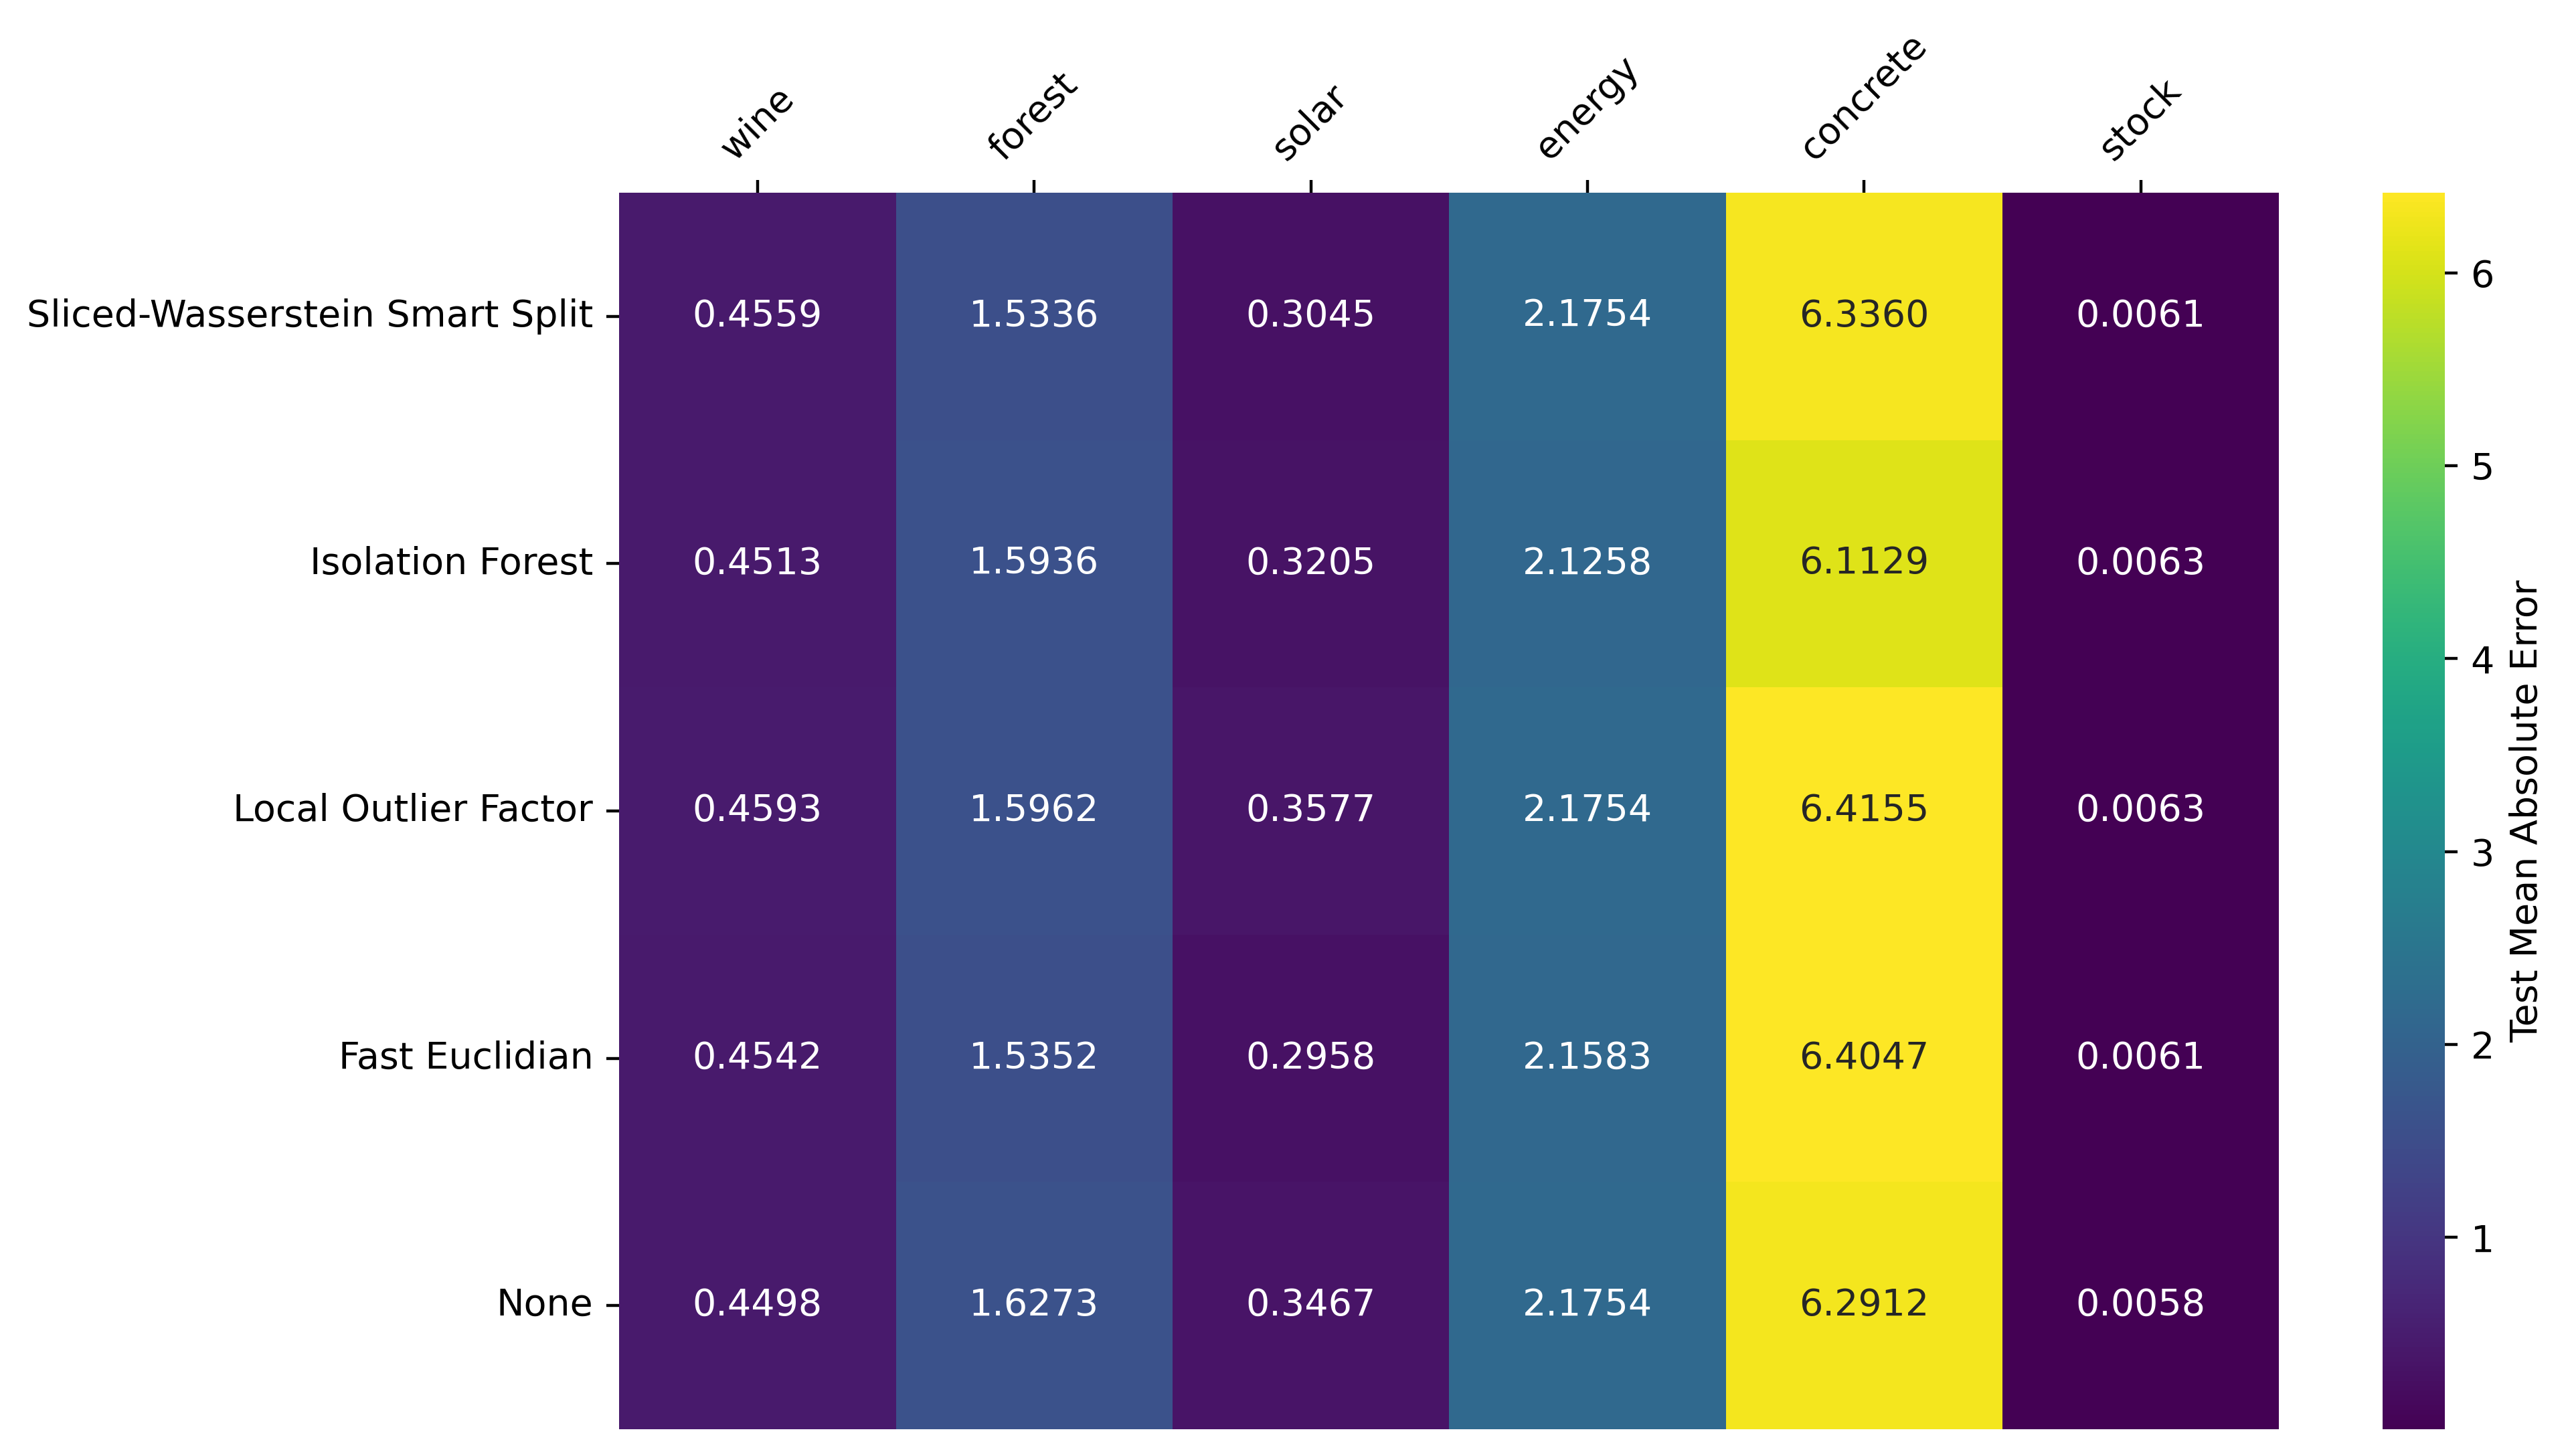

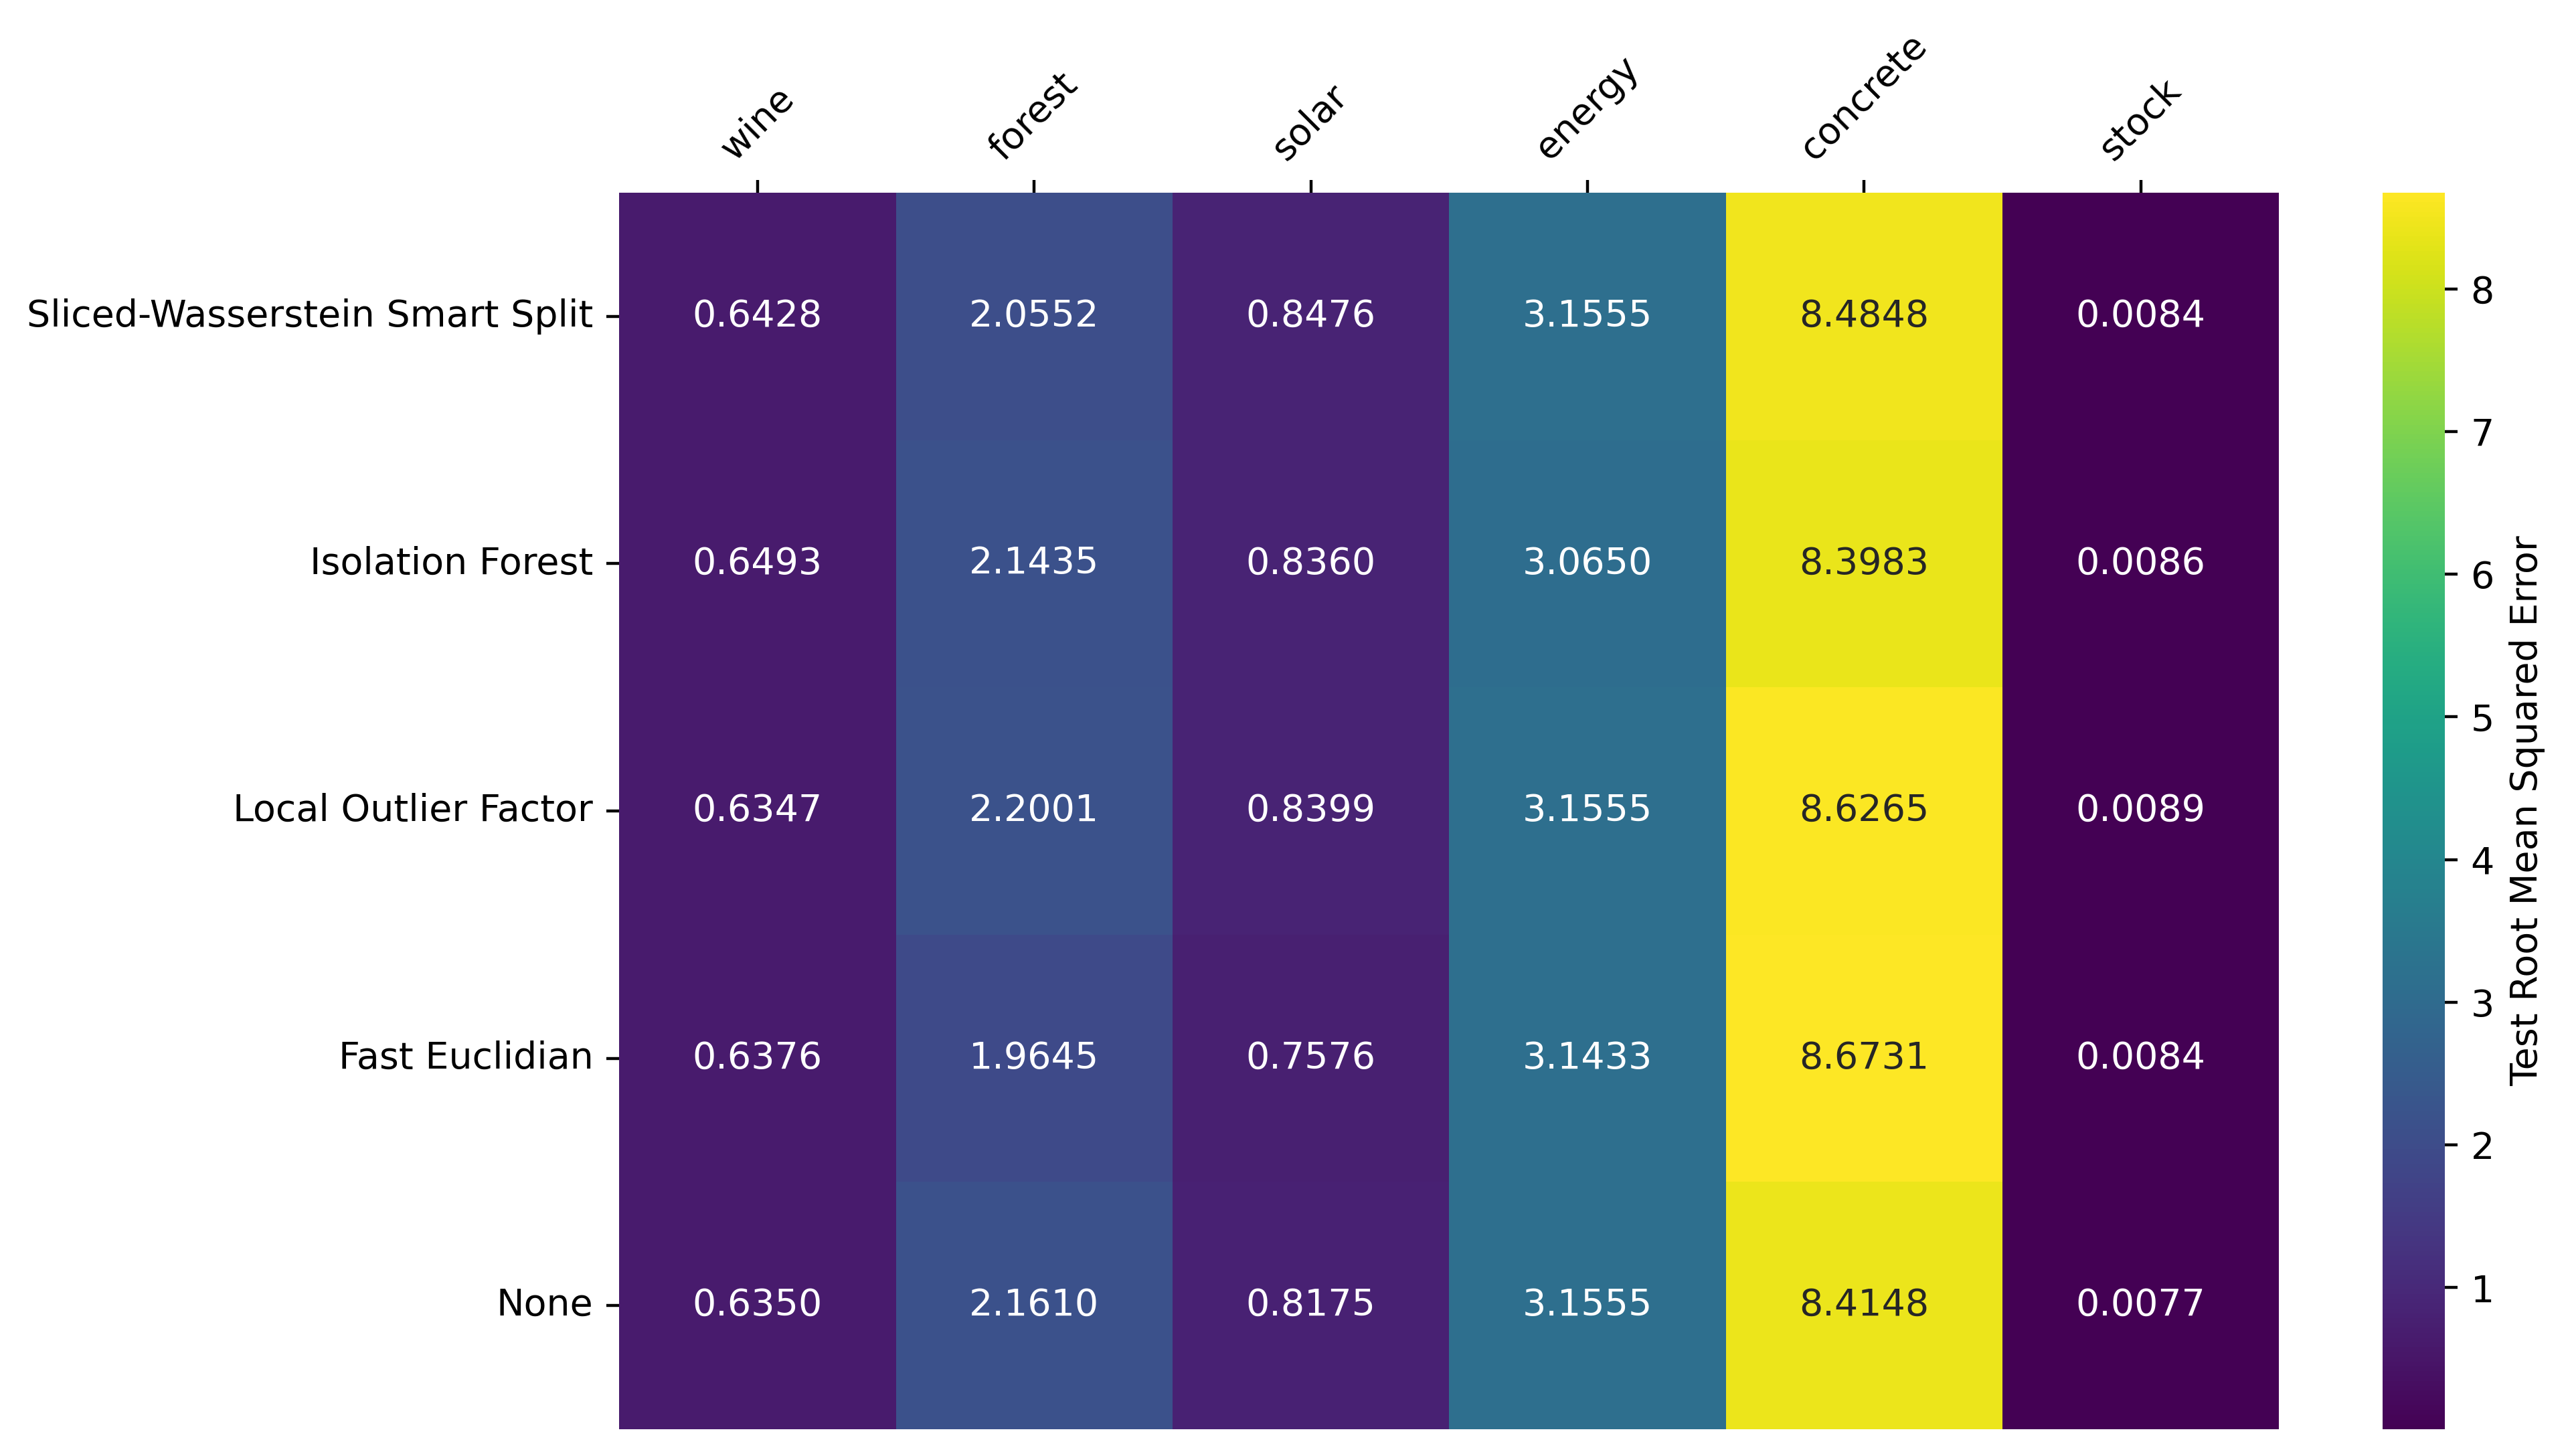

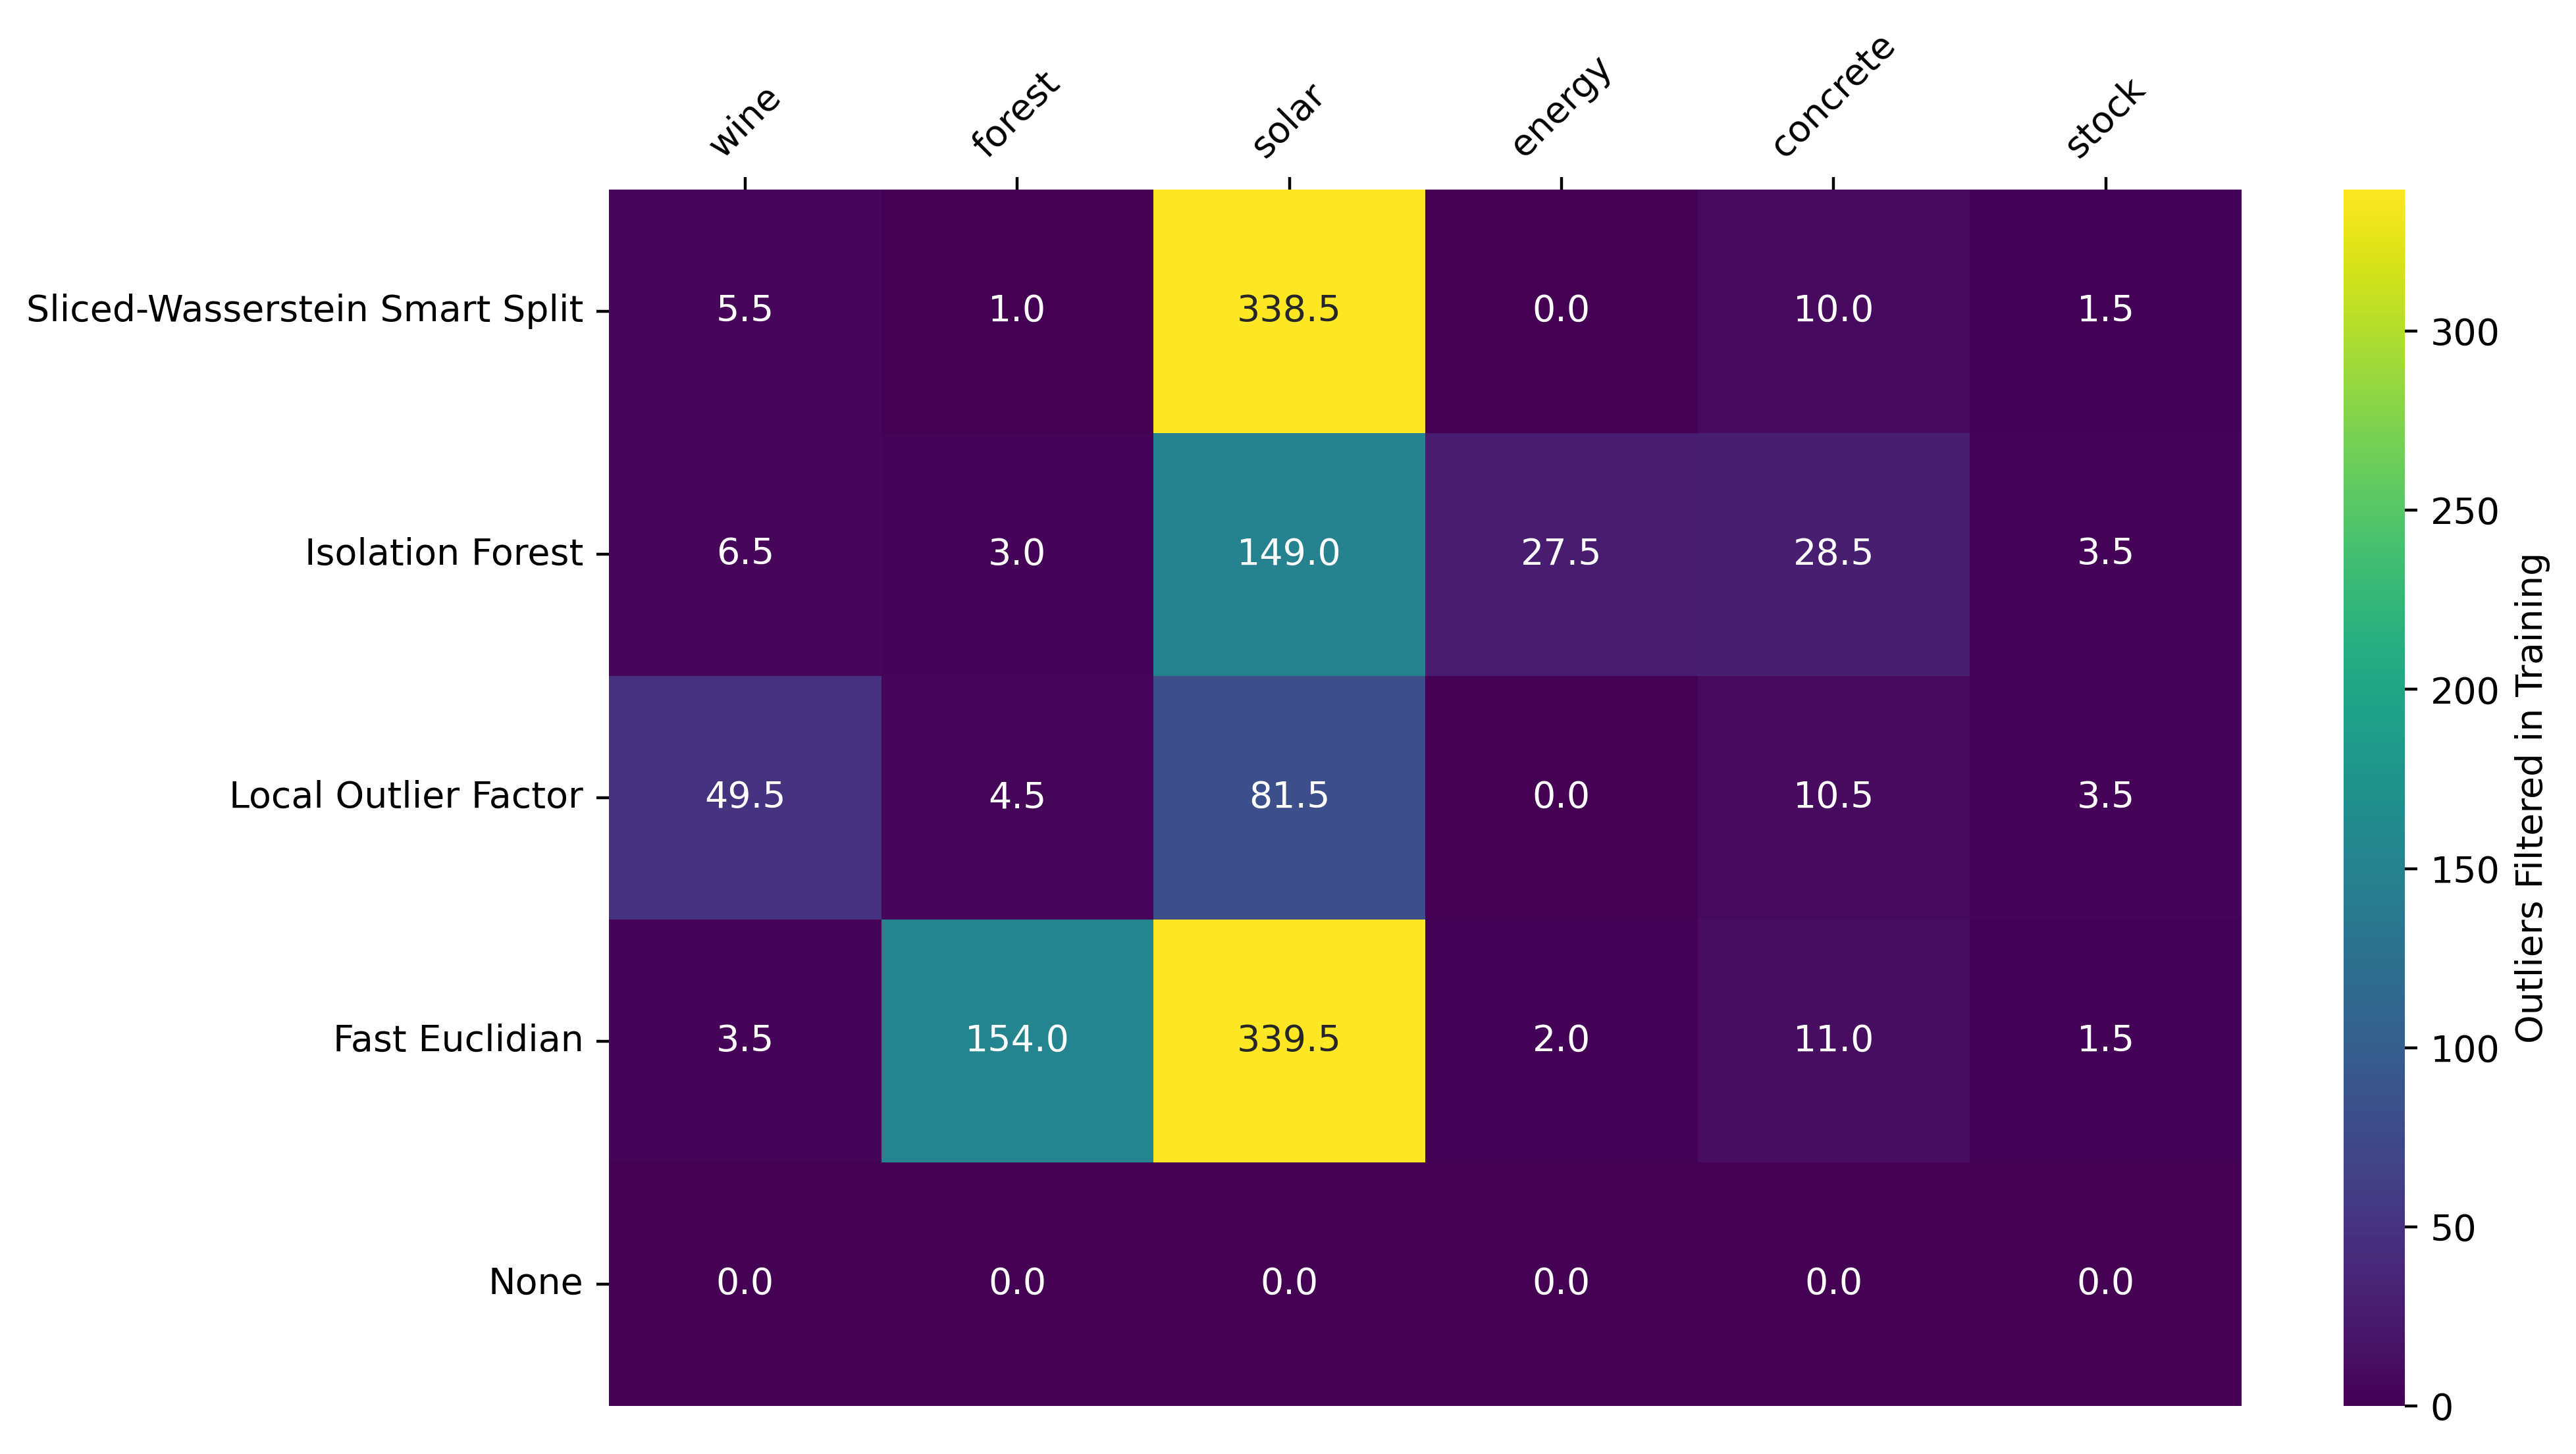

In [13]:
data = data_MAE
# Normalize each column by its range


plt.figure(figsize=(10, 6), dpi = 400)
#plt.tight_layout()
cmap = sns.color_palette("viridis", as_cmap=True)
heatmap = sns.heatmap(data.astype(float), cmap=cmap, annot=True, fmt=".4f",cbar_kws={'label': 'Test Mean Absolute Error'})

# Set the function names as the y-axis labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

# Set the function names as the x-axis labels and place them on top
heatmap.set_xticklabels(data.columns, rotation=45)
heatmap.xaxis.tick_top()

#plt.title('Your caption here', y=-0.1)
#plt.title('Normalized error metrics for different models and benchmark functions')
plt.savefig('data_selection_MAE.pdf', bbox_inches='tight')
plt.show()

data = data_RMSE


plt.figure(figsize=(10, 6), dpi = 400)
#plt.tight_layout()
cmap = sns.color_palette("viridis", as_cmap=True)
heatmap = sns.heatmap(data.astype(float), cmap=cmap, annot=True, fmt=".4f",cbar_kws={'label': 'Test Root Mean Squared Error'})

# Set the function names as the y-axis labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

# Set the function names as the x-axis labels and place them on top
heatmap.set_xticklabels(data.columns, rotation=45)
heatmap.xaxis.tick_top()

#plt.title('Your caption here', y=-0.1)
#plt.title('Normalized error metrics for different models and benchmark functions')
plt.savefig('data_selection_RMSE.pdf', bbox_inches='tight', dpi=400)
plt.show()

data = data_outliers
plt.figure(figsize=(10, 6), dpi = 400)
#plt.tight_layout()
cmap = sns.color_palette("viridis", as_cmap=True)
heatmap = sns.heatmap(data.astype(float), cmap=cmap, annot=True, fmt=".1f",cbar_kws={'label': 'Outliers Filtered in Training'})

# Set the function names as the y-axis labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

# Set the function names as the x-axis labels and place them on top
heatmap.set_xticklabels(data.columns, rotation=45)
heatmap.xaxis.tick_top()

#plt.title('Your caption here', y=-0.1)
#plt.title('Normalized error metrics for different models and benchmark functions')
plt.savefig('data_selection_outliers.pdf', bbox_inches='tight', dpi=400)
plt.show()
